In [1]:
from tensorflow.keras.datasets.mnist import load_data

In [2]:
(X_train, _),(_, _) = load_data()

In [3]:
print("Data shape:", X_train.shape)

Data shape: (60000, 28, 28)


In [4]:
import matplotlib.pyplot as plt

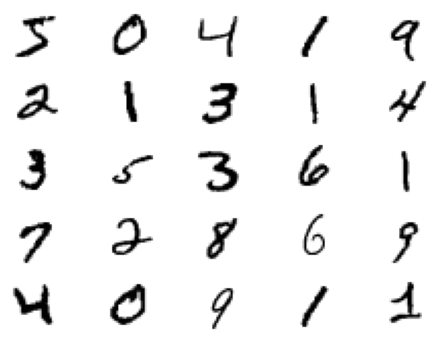

In [5]:
plt.figure(figsize=(8,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis("off")
    plt.imshow(X_train[i], cmap="gray_r")
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [7]:
def define_discriminator(input_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [8]:
import numpy as np

In [9]:
X = np.expand_dims(X_train, -1)

In [10]:
X.astype("float32")
X = X/127.5 - 1

In [11]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = 0.7 + (np.random.random(n_samples) * 0.5)
    return X, y.reshape((n_samples, 1))

In [12]:
from tensorflow.keras.layers import Conv2DTranspose, Reshape
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128*7*7, input_dim = latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1, kernel_size=(7,7), activation="tanh", padding="same"))
    
    model.summary()
    return model

In [13]:
def generate_latent_points(latent_dim, n_samples):
    X_input = np.random.randn(latent_dim*n_samples)
    X_input = X_input.reshape((n_samples, latent_dim))
    return X_input

In [14]:
def generate_fake_samples(generator, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(X_input)
    y = np.random.random(n_samples) * 0.3
    return X, y.reshape((n_samples, 1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       2

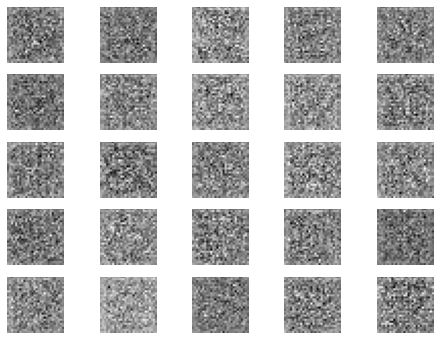

In [15]:
generator = define_generator(100)
X_fake_samples, _ = generate_fake_samples(generator, 100, 25)
plt.figure(figsize=(8,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis("off")
    plt.imshow(X_fake_samples[i,:,:,0], cmap="gray_r")
plt.savefig("mnist_gen/Epoch_0.png")
plt.show()

In [16]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=optimizer, loss="binary_crossentropy")
    model.summary()
    return model

In [17]:
def hard_y(y):
  for i in range(len(y)):
    if y[i] <= 0.3:
      y[i] = 0
    else:
      y[i] = 1
  return y

In [18]:
from IPython.display import clear_output
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n=100):
    clear_output()
    X_real, y_real = generate_real_samples(dataset, n)
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    y_real = hard_y(y_real)
    y_fake = hard_y(y_fake)
    plt.figure(figsize=(10,8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis("off")
        plt.imshow(X_fake[i,:,:,0], cmap="gray_r")
    plt.savefig("mnist_gen/Epoch_"+str(epoch+1)+".png")
    plt.show()
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
    _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose=0)
    print("\nEpoch %4d => Real Accuracy = %.3f, Fake Accuracy = %.3f"%(epoch+1,acc_real,acc_fake))

In [19]:
from tqdm import tqdm
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=100, n_batch=256):
    batch_per_epoch = dataset.shape[0]//n_batch
    half_batch = n_batch//2
    for i in range(n_epochs):
        d_loss = gan_loss = 0
        for j in tqdm(range(batch_per_epoch)):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = discriminator.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = 0.7 + (np.random.random(n_batch) * 0.5)
            y_gan = y_gan.reshape((n_batch, 1))
            gan_loss = gan.train_on_batch(X_gan, y_gan)
        summarize_performance(i, generator, discriminator, dataset, latent_dim)
        print("\nDiscriminator Loss: %.3f, GAN Loss: %.3f"%(d_loss, gan_loss))

In [20]:
latent_dim = 50

In [21]:
generator = define_generator(latent_dim)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              319872    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)      

In [22]:
discriminator = define_discriminator()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)         

In [23]:
model = define_gan(generator, discriminator)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         851713    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 41217     
Total params: 892,930
Trainable params: 851,201
Non-trainable params: 41,729
_________________________________________________________________


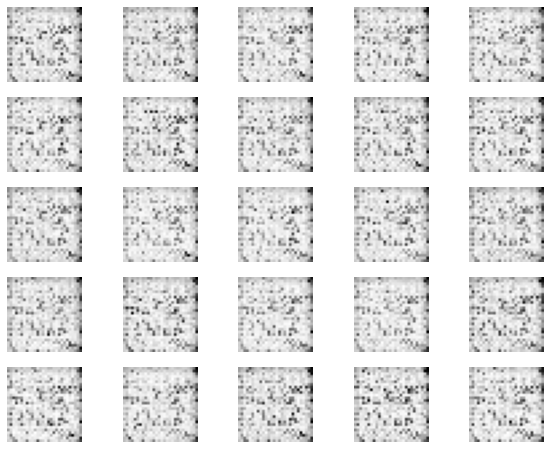

  0%|                                                                                                                                                                                     | 0/234 [00:00<?, ?it/s]


Epoch    1 => Real Accuracy = 1.000, Fake Accuracy = 0.000

Discriminator Loss: 0.324, GAN Loss: 0.223


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 135/234 [00:48<00:35,  2.81it/s]


KeyboardInterrupt: 

In [24]:
train(generator, discriminator, model, X, latent_dim, n_epochs=200)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.29it/s]


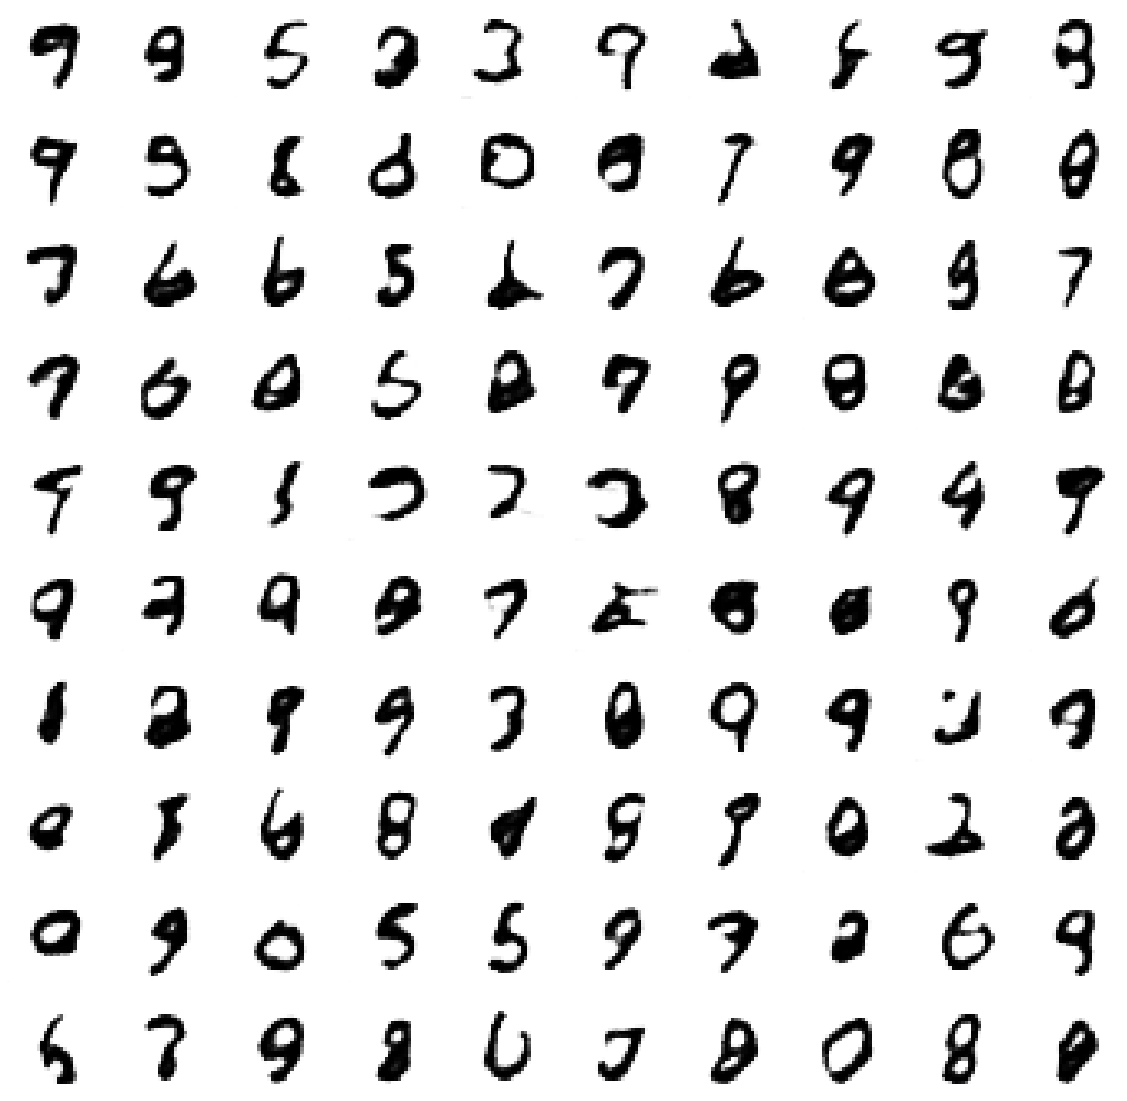

In [31]:
from tqdm import tqdm
plt.figure(figsize=(20, 20))
for i in tqdm(range(100)):
  plt.subplot(10,10,i+1)
  plt.axis("off")
  predict = generator.predict(np.random.random((1,latent_dim))*2-1)
  plt.imshow(predict[0,:,:,0], cmap="gray_r")
plt.savefig("mnist_gen/final.png")
plt.show()